In [2]:
import argparse
import tifffile
import zarr
import sys
import umap
import numpy as np
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
import matplotlib.pyplot as plt
from matplotlib.image import imsave
from sklearn.preprocessing import MinMaxScaler
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects

In [3]:
def str2bool(v):
    if isinstance(v, bool):
       return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        
def pull_pyramid(input, level):
    
    print("Loading image")
    
    tiff = tifffile.TiffFile(input, is_ome=False)
    tiff_levels = tiff.series[0].levels
    highest_level_tiff = tiff_levels[level]
    zarray = zarr.open(highest_level_tiff.aszarr())

    print("Opened image pyramid level:", level)
    print("Image dimensions:", zarray.shape)

    return(zarray)
    
def remove_background(zarray):
    print("Finding background")
    sum_image = np.array(zarray).sum(axis = 0)
    pseudocount = 1
    log_image = np.log2(sum_image + pseudocount)
    thresh = threshold_otsu(log_image)
    binary = log_image > thresh
    cleaned = remove_small_objects(binary)
    print("Background removed")
    def get_tissue(x):
        return x[cleaned]
    tissue_array = list(map(get_tissue, zarray))
    tissue_array = np.array(tissue_array).T
    print("Selected", tissue_array.shape[0], "of", zarray.shape[1]*zarray.shape[2], "pixels as tissue")
    print("Pixels x channels matrix prepared")
    print(tissue_array.shape)
    return tissue_array,cleaned
    
def keep_background(zarray):
    print("Preserving background")
    shape = zarray.shape[1:]
    everything = np.ones(shape, dtype=bool)
    def get_all(x):
        return x[everything]
    return(everything)
    tissue_array = list(map(get_all, zarray))
    tissue_array = np.array(tissue_array).T
    print("Pixels x channels matrix prepared")
    print(tissue_array.shape)
    return tissue_array,everything
    
def run_umap(tissue_array):
    reducer = umap.UMAP(
        n_components = 3,
        metric = "correlation",
        min_dist = 0,
        verbose = True)
    print("Running UMAP")
    embedding = reducer.fit_transform(tissue_array)
    return(embedding)
    
def embedding_to_lab_to_rgb(x):
        #print("Converting embedding to LAB colour")
        lab = LabColor(x[2], x[0], x[1])
        #print("Converting LAB to RGB for display")
        rgb = convert_color(lab, sRGBColor)
        #print("Clamping RGB values")
        clamped_rgb = sRGBColor(rgb.clamped_rgb_r, rgb.clamped_rgb_g, rgb.clamped_rgb_b)
        return clamped_rgb.get_value_tuple()
    
def assign_colours(embedding):
    print("Assigning colours to pixels embedding in low dimensional space")
    print("Rescaling embedding")
    scaler = MinMaxScaler(feature_range = (-128,127))
    dim1 = scaler.fit_transform(embedding[:,0].reshape(-1,1))
    dim2 = scaler.fit_transform(embedding[:,1].reshape(-1,1))
    scaler = MinMaxScaler(feature_range = (10,80))
    dim3 = scaler.fit_transform(embedding[:,2].reshape(-1,1))
    
    rescaled_embedding = np.concatenate((dim1,dim2,dim3), axis = 1)
    rescaled_embedding_list = rescaled_embedding.tolist()
    rgb = list(map(embedding_to_lab_to_rgb, rescaled_embedding_list))
    rgb = np.array(rgb)
    print("Colours assigned")
    return(rgb)
    
def make_rgb_image(rgb, mask):
    print("Painting miniature")
    rgb_shape = list(mask.shape)
    rgb_shape.append(3)
    rgb_image = np.zeros(rgb_shape)
    rgb_image[mask] = rgb
    return(rgb_image)

def plot_embedding(embedding, rgb, size=20):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter3D(
        embedding[:,0], 
        embedding[:,1], 
        embedding[:,2], 
        c = rgb,
        s = size,
        edgecolors = 'none'
        )
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    plt.show()

In [4]:
path = '/rapids/adamjtaylor-data/HTA9_1_BA_L_ROI04.ome.tif'

In [5]:
zarray = pull_pyramid(path, 1)

Loading image
Opened image pyramid level: 1
Image dimensions: (12, 1156, 1937)


In [6]:
tissue_array,cleaned = remove_background(zarray)

Finding background
Background removed
Selected 1321579 of 2239172 pixels as tissue
Pixels x channels matrix prepared
(1321579, 12)


In [ ]:
%%time
embedding_umap = run_umap(tissue_array)

In [23]:
rgb_umap = assign_colours(embedding_umap)
image_umap = make_rgb_image(rgb_umap, cleaned)

Assigning colours to pixels embedding in low dimensional space
Rescaling embedding
Colours assigned
Painting miniature


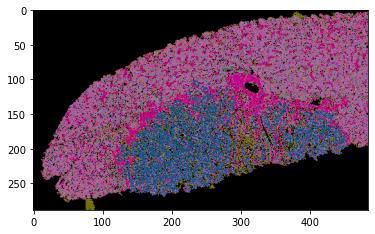

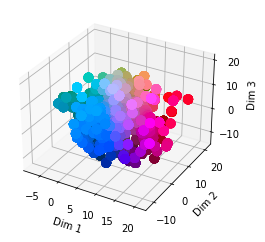

trustworthiness score :  0.7647934106642273


In [122]:
plt.imshow(image_umap)
plot_embedding(embedding_umap, rgb_umap)
cu_score = cuml.metrics.trustworthiness( tissue_array, embedding_umap )
print("trustworthiness score : ", cu_score )

In [7]:
import cuml

In [8]:
%%time
reducer_rapids = cuml.UMAP(
        n_components = 3,
            min_dist = 0,
        verbose = True)
embedding_rapids = reducer_rapids.fit_transform(tissue_array)

[D] [13:05:18.614787] ../src/umap/runner.cuh:98 n_neighbors=15
[D] [13:05:18.624005] ../src/umap/runner.cuh:122 Calling knn graph run
[D] [13:06:32.542850] ../src/umap/runner.cuh:128 Done. Calling fuzzy simplicial set
[D] [13:06:32.556865] ../src/umap/fuzzy_simpl_set/naive.cuh:301 Smooth kNN Distances
[D] [13:06:32.557908] ../src/umap/fuzzy_simpl_set/naive.cuh:303 sigmas = [ 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0006, 0.0006, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 0.0373293, 6.35541, 2.05605, 0.0373293, 0.0373293, 0.0373293 ]

[D] [13:06:32.557977] ../src/umap/fuzzy_simpl_set/naive.cuh:305 rhos = [    0,    0,    0,    0,    0,    0,    1,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   11,    1,    0,    0,    0 ]

[D] [13:06:32.558018] ../src/umap/fuzzy_simpl_set/naive.cuh:323 Compute Membership Strength
[D] [13:06:46.844038] ../src/umap/fuzz

In [9]:
rgb_rapids = assign_colours(embedding_rapids)
image_rapids = make_rgb_image(rgb_rapids, cleaned)

Assigning colours to pixels embedding in low dimensional space
Rescaling embedding
Colours assigned
Painting miniature


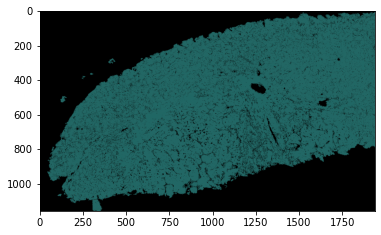

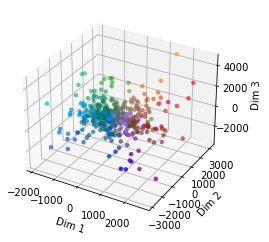

In [ ]:
plt.imshow(image_rapids)
plot_embedding(embedding_rapids, rgb_rapids)
cu_score = cuml.metrics.trustworthiness( tissue_array, embedding_rapids )
print("trustworthiness score : ", cu_score )

In [94]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
tissue_array_scaled = robust_scaler.fit_transform(tissue_array)

In [95]:
%%time

embedding_rapids_scaled = reducer_rapids.fit_transform(tissue_array_scaled)

[D] [12:08:45.123893] cuml/common/logger.cpp:3080 Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
[D] [12:08:45.127018] ../src/umap/runner.cuh:98 n_neighbors=15
[D] [12:08:45.127400] ../src/umap/runner.cuh:122 Calling knn graph run
[D] [12:08:45.668306] ../src/umap/runner.cuh:128 Done. Calling fuzzy simplicial set
[D] [12:08:45.670938] ../src/umap/fuzzy_simpl_set/naive.cuh:301 Smooth kNN Distances
[D] [12:08:45.671054] ../src/umap/fuzzy_simpl_set/naive.cuh:303 sigmas = [ 5.96046e-11, 0.0140405, 0.0140405, 0.0140405, 0.0140405, 0.0140405, 0.0140405, 0.0140405, 0.0140405, 0.249334, 6.23517, 1.2347, 2.47739, 1.71116, 0.0140405, 0.0140405, 0.00926816, 0.0140405, 1.6156, 0.403332, 1.64155e-06, 0.0140405, 0.0140405, 22.2208, 0.0140405 ]

[D] [12:08:45.671110] ../src/umap/fuzzy_simpl_set/naive.cuh:305 rhos = [ 5.96046e-08,    0,    0,    0,    0,    0,    0,    0,    0, 0.619253, 15.2243, 4.41123, 1.52588e-05, 2.34415, 

In [98]:
rgb_rapids_scaled = assign_colours(embedding_rapids_scaled)
image_rapids_scaled = make_rgb_image(rgb_rapids_scaled, cleaned)

Assigning colours to pixels embedding in low dimensional space
Rescaling embedding
Colours assigned
Painting miniature


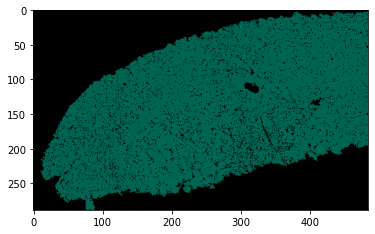

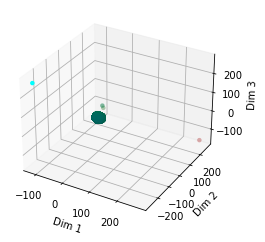

In [125]:
plt.imshow(image_rapids_scaled)
plot_embedding(embedding_rapids_scaled, rgb_rapids_scaled)

In [115]:
from cupy import asnumpy
from cuml.datasets import make_blobs
from cuml.manifold.umap import UMAP as cuUMAP
from sklearn.manifold import trustworthiness
import numpy as np

n_samples = 1000
n_features = 100
cluster_std = 0.1

X_blobs, y_blobs = make_blobs( n_samples = n_samples,
                               cluster_std = cluster_std,
                               n_features = n_features,
                               random_state = 0,
                               dtype=np.float32 )

trained_UMAP = cuUMAP( n_neighbors = 10 ).fit( X_blobs )
X_embedded = trained_UMAP.transform( X_blobs )

cu_score = cuml.metrics.trustworthiness( X_blobs, X_embedded )
sk_score = trustworthiness( asnumpy( X_blobs ),  asnumpy( X_embedded ) )

print(" cuml's trustworthiness score : ", cu_score )
print(" sklearn's trustworthiness score : ", sk_score )

 cuml's trustworthiness score :  0.8503028225806452
 sklearn's trustworthiness score :  0.8503459677419355
